# <font size="7">📝 **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [34]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 6

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")


Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [35]:
#  adding radial feature to input
r=torch.sqrt(X_full[:,0]**2+X_full[:,1]**2).view(-1,1)  # 3000 x 1
X_full=torch.cat((X_full,r),dim=1) # 3000 x 3
print("X_full.shape:",X_full.shape)

X_full.shape: torch.Size([3000, 3])


In [36]:
# splitting into training and testing datas randomnly
n_samples=X_full.shape[0]
n_train=int(0.7*n_samples)
n_test=n_samples-n_train
idx=torch.randperm(3000) # make a matrix of size 3000 x 1 which carries indices from 0 to 2999 randomnly
 # training datas with labels in random order from X_full
X_train=X_full[idx[:n_train]]
y_train=y_full[idx[:n_train]]
  # testing datas with labels in random order from y_full
X_val=X_full[idx[n_train:]]
y_val=y_full[idx[n_train:]]

print(f"Training Data: {X_train.shape} samples.")
print(f"Training Labels: {y_train.shape} labels.")
print(f"Validation Data: {X_val.shape} samples.")
print(f"Validation Labels: {y_val.shape} labels.")
print("\nX_train:")
print(X_train)
print("\ny_train:")
print(y_train)
print("\nX_val:")
print(X_val)
print("\ny_val:")
print(y_val)



Training Data: torch.Size([2100, 3]) samples.
Training Labels: torch.Size([2100, 1]) labels.
Validation Data: torch.Size([900, 3]) samples.
Validation Labels: torch.Size([900, 1]) labels.

X_train:
tensor([[-2.2764, -0.0963,  2.2785],
        [ 0.6332,  4.0544,  4.1036],
        [ 3.0172,  0.2906,  3.0312],
        ...,
        [-3.1858, -4.7229,  5.6969],
        [-1.5109, -2.9548,  3.3187],
        [-3.9344,  2.4599,  4.6401]])

y_train:
tensor([[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]])

X_val:
tensor([[-1.2299, -1.5374,  1.9688],
        [-0.5888, -2.2560,  2.3316],
        [-3.2993, -4.1401,  5.2939],
        ...,
        [ 1.8087,  2.5792,  3.1502],
        [ 3.2156,  0.6480,  3.2802],
        [-4.4181,  0.5678,  4.4544]])

y_val:
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0

In [37]:
# sigmoid function
def sigmoid(x):
  return torch.sigmoid(x)

In [52]:
# training the neural network using gradient descent method

class NeuralNetwork():
   def __init__(self,epoch,learning_rate):
      self.epoch=epoch
      self.learning_rate=learning_rate
      #  initializing neural network of 3  hidden layers with 16 neurons in each layer with 4 weight and 4 bias matrices
# input matrix X_train of size 2100 x 2
# weight  and bias matrix of first layer
# requires_grad=True tracks the operations and last help in cacluating gradients
      self.w1=torch.randn(3,16,dtype=torch.float32,requires_grad=True) # floating values
      self.b1=torch.zeros(1,16,dtype=torch.float32,requires_grad=True)
# weight and bias matrix of second layer
# for second layer output from 1st layer will be input matrix of size 2100 x 16
      self.w2=torch.randn(16,16,dtype=torch.float32,requires_grad=True)
      self.b2=torch.zeros(1,16,dtype=torch.float32,requires_grad=True)
# weigth and bias matrix of third layer
      self.w3=torch.randn(16,16,dtype=torch.float32,requires_grad=True)
      self.b3=torch.zeros(1,16,dtype=torch.float32,requires_grad=True)
# weight and bias matirx for output layer
# same as logistic regression with non linear input from third layer
      self.w4=torch.randn(16,1,dtype=torch.float32,requires_grad=True)
      self.b4=torch.zeros(1,1,dtype=torch.float32,requires_grad=True)
      self.train_loss=[]
      self.test_loss=[]



   def train(self,X_train,y_train,X_val,y_val):
    for i in range(self.epoch):
  # forward pass of training datas
  # through first layer
      z1=torch.matmul(X_train,self.w1)+self.b1  # of size 2100 x 16
  # from relu function for non linarity
      a1=torch.relu(z1) # of size 2100 X 16
  # a1 will be input for second layer
  # Second layer
      z2=torch.matmul(a1,self.w2)+self.b2 # of size 2100 x 16
  # from relu function
      a2=torch.relu(z2) # of size 2100 x 16
  # a2 will be input for 3rd layer
  # Third layer
      z3=torch.matmul(a2,self.w3)+self.b3 # of size 2100 x 16
  # from relu function
      a3=torch.relu(z3) # of size 2100 x 16
  # Output layer same as logistic regression with non linaer input a3
      z4=torch.matmul(a3,self.w4)+self.b4 # of size 2100 x 1
  # passing it from sigmoid function to normalize it in [0-1]
      y_cap=sigmoid(z4) # of size 2100 x 1 contains probablities of being in dead zone

  # calculating loss manually
      epsilon=1e-8
  # clamping b/w a range to avoid log(0)
      y_cap=torch.clamp(y_cap,epsilon,1-epsilon)
  #  binary entropy error
      loss_train=-torch.mean(y_train*torch.log(y_cap+epsilon)+(1-y_train)*torch.log(1-y_cap+epsilon))
      self.train_loss.append(loss_train.item())

  # forward pass for testing datas
      with torch.no_grad():
  # 1st layer
        Z1=torch.matmul(X_val,self.w1)+self.b1
        A1=torch.relu(Z1)
  # 2nd layer
        Z2=torch.matmul(A1,self.w2)+self.b2
        A2=torch.relu(Z2)
  #3rd layer
        Z3=torch.matmul(A2,self.w3)+self.b3
        A3=torch.relu(Z3)
  # output layer
        Z4=torch.matmul(A3,self.w4)+self.b4
        y_cap_test=sigmoid(Z4)
  # test_loss
        y_cap_test=torch.clamp(y_cap_test,epsilon,1-epsilon)
        loss_test=  -torch.mean(y_val*torch.log(y_cap_test+epsilon)+(1-y_val)*torch.log(1-y_cap_test+epsilon))
        self.test_loss.append(loss_test.item())





# Backward pass
  # calculating gradients w.r.t w1,w1,w3,w4,b1,b1,b3,b4 which requires_grad=True
      loss_train.backward()
  # this will calculate derivative of loss wrt weigths and biases and store in x.grad

  # updating weights and biases manually but under with torch.no_grad(): beacuse we dont want to track these update operations
  # otherwise gradients will track these and cacluate derivative wrt to old weight and bias
      with torch.no_grad():
    #  elemant wise operations
        self.w1-=self.learning_rate*self.w1.grad
        self.b1-=self.learning_rate*self.b1.grad
        self.w2-=self.learning_rate*self.w2.grad
        self.b2-=self.learning_rate*self.b2.grad
        self.w3-=self.learning_rate*self.w3.grad
        self.b3-=self.learning_rate*self.b3.grad
        self.w4-=self.learning_rate*self.w4.grad
        self.b4-=self.learning_rate*self.b4.grad

  # setting gradients again zero to avoid accumpalating
      self.w1.grad.zero_()
      self.b1.grad.zero_()
      self.w2.grad.zero_()
      self.b2.grad.zero_()
      self.w3.grad.zero_()
      self.b3.grad.zero_()
      self.w4.grad.zero_()
      self.b4.grad.zero_()


   def predict_prob(self,X_train):
        # forward pass
  # through first layer
      z1=torch.matmul(X_train,self.w1)+self.b1  # of size 2100 x 16
  # from relu function for non linarity
      a1=torch.relu(z1) # of size 2100 X 16
  # a1 will be input for second layer
  # Second layer
      z2=torch.matmul(a1,self.w2)+self.b2 # of size 2100 x 16
  # from relu function
      a2=torch.relu(z2) # of size 2100 x 16
  # a2 will be input for 3rd layer
  # Third layer
      z3=torch.matmul(a2,self.w3)+self.b3 # of size 2100 x 16
  # from relu function
      a3=torch.relu(z3) # of size 2100 x 16
  # Output layer same as logistic regression with non linaer input a3
      z4=torch.matmul(a3,self.w4)+self.b4 # of size 2100 x 1
  # passing it from sigmoid function to normalize it in [0-1]
      y_cap=sigmoid(z4) # of size 2100 x 1 contains probablities of being in dead zone
      return y_cap
   def predict(self,y_cap):
       # thresholding at 0.5
       y_predict=(torch.zeros_like(y_cap)).to(torch.float32)
       y_predict[y_cap>0.5]=1.0  # dead zone
       return y_predict


Training Accuracy:
0.87

Testing Accuracy:
0.8444444444444444


Training loss for 10 epochs:
[6.7369608879089355, 6.603948593139648, 5.51077938079834, 6.746470928192139, 5.605969429016113, 6.50848388671875, 7.079308986663818, 6.504762172698975, 6.7872538566589355, 6.7869415283203125]

Testing loss for 10 epochs:
[6.68891716003418, 6.568216323852539, 5.81078577041626, 7.229440212249756, 5.944741249084473, 6.508842468261719, 7.363407135009766, 6.87460994720459, 6.746636390686035, 6.746537685394287]




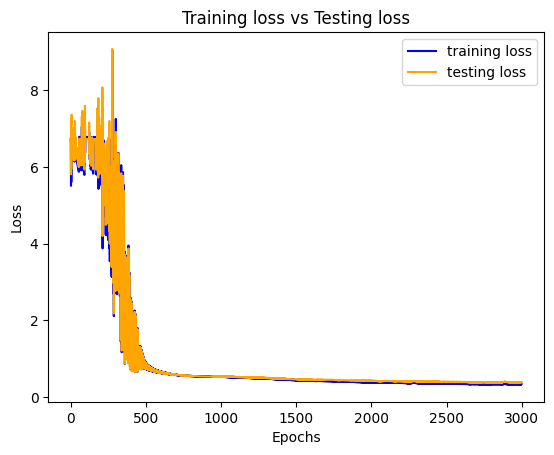

In [53]:
import matplotlib.pyplot as plt
# create a model
model=NeuralNetwork(3000,0.01)
# train it
model.train(X_train,y_train,X_val,y_val)
# predicting training probablities and labels with training accurracy
y_cap_prob=model.predict_prob(X_train)
y_predict=model.predict(y_cap_prob)
training_accuracy=(y_predict==y_train).sum().item()/y_train.shape[0]
print("Training Accuracy:")
print(training_accuracy)

# for testing datas
y_cap_prob_test=model.predict_prob(X_val)
y_predict_test=model.predict(y_cap_prob_test)
testing_accuracy=(y_predict_test==y_val).sum().item()/y_val.shape[0]
print("\nTesting Accuracy:")
print(testing_accuracy)
print("\n")

print("Training loss for 10 epochs:")
print(model.train_loss[:10])
print("\nTesting loss for 10 epochs:")
print(model.test_loss[:10])
print("\n")

# plotting training loss and testing loss curve

plt.plot(model.train_loss,label="training loss",color="blue")
plt.plot(model.test_loss,label="testing loss",color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss vs Testing loss")
plt.legend()
plt.show()







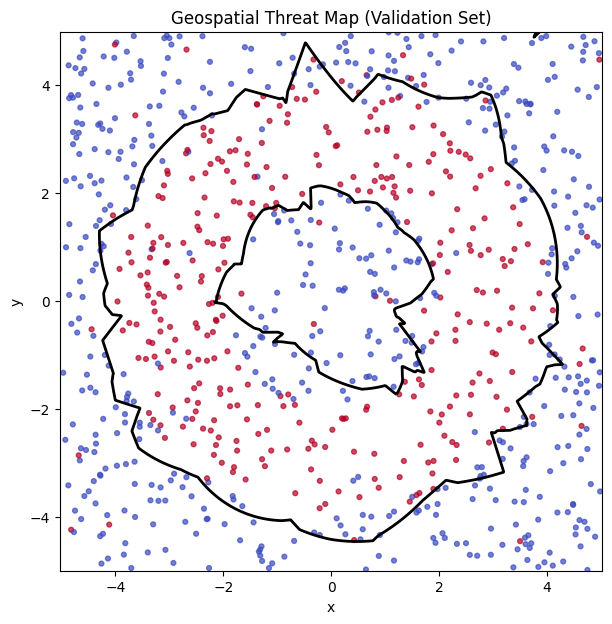

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# 1. Create 2D grid

x_min, x_max = -5, 5
y_min, y_max = -5, 5
step = 0.01

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step),
    np.arange(y_min, y_max, step)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

grid_xy = torch.tensor(grid_points, dtype=torch.float32)

grid_r = torch.sqrt(
    grid_xy[:, 0]**2 + grid_xy[:, 1]**2
).view(-1, 1)

# convert to tensor

grid_tensor = torch.cat([grid_xy, grid_r], dim=1)



#  Predict probabilities on grid

with torch.no_grad():
    probs = model.predict_prob(grid_tensor)

Z = probs.reshape(xx.shape).cpu().numpy()


# 3. Plot decision boundary

plt.figure(figsize=(7,7))

# Decision boundary at confidence = 0.5
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
# 4. Overlay VALIDATION data

plt.scatter(
    X_val[:,0].cpu(),
    X_val[:,1].cpu(),
    c=y_val[:,0].cpu(),
    cmap='coolwarm',
    s=12,
    alpha=0.7
)


# 5. Labels and formatting

plt.xlabel("x")
plt.ylabel("y")
plt.title("Geospatial Threat Map (Validation Set)")
plt.axis("equal")
plt.show()
